# Project 3: Text classification with Naive Bayes 

## Name: Abhishek Kumar Sharma
## Student Id: 5037 2679
## Class: MTH 548
## Date: March 14, 2023

# Introduction

In this project, you will be working with 3 datasets:
$$(1) \text{1 or more presidential debate transcripts that you scraped last week.}$$

$$(2) \text{movie_reviews.zip}$$

The file movie_reviews.zip is a zipped csv file containing texts of about 25,000 movie reviews. Each review is accompanied by a label, indicating if the review is positive or negative.

We begin by implementing model for movie reviews using Naive Bayes. The idea is to create a training data set and we will create a dataframe with two columns “positive” and “negative”. Rows of the dataframe labeled by words appearing in the text of the reviews. The entries of a row will show how many times the given word appears in the text of negative reviews and how many times it appears in positive reviews.

We will do this by preprocessing the data, which includes cleaning of data, tokenization and removing of stopwords and then creating the dataframe.

### Importing Libraries

In [3]:
import pandas as pd                                        # To work with dataframes
import matplotlib.pyplot as plt                            # To plot graphs if required
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split       # To create the training and test dataset
import re
from bs4 import BeautifulSoup
import numpy as np                                          
import requests
from tqdm import tqdm
from sklearn.metrics import accuracy_score                  # To check the accuracy score of the model

### Importing datasets

In [2]:
movies = pd.read_csv("movie_reviews.zip")   # creating the dataframe for movie reviews
movies[:3]

,review,sentiment
0,"This film is absolutely awful, but nevertheles...",negative
1,Well since seeing part's 1 through 3 I can hon...,negative
2,I got to see this film at a preview and was da...,positive


The dataset contains uppercase and lowercase letters. So we convert the reviews in the lowercase so that it is easy for us to process the data.

In [3]:
movies["review"] = movies["review"].str.lower()   # Converting every review into lowercase

In [4]:
movies

,review,sentiment
0,"this film is absolutely awful, but nevertheles...",negative
1,well since seeing part's 1 through 3 i can hon...,negative
2,i got to see this film at a preview and was da...,positive
3,this adaptation positively butchers a classic ...,negative
4,råzone is an awful movie! it is so simple. it ...,negative
...,...,...
24995,with this movie being the only dirty harry mov...,positive
24996,any screen adaptation of a john grisham story ...,positive
24997,this film captured my heart from the very begi...,positive
24998,a deplorable social condition triggers off the...,positive


### Data Preprocessing

The following function do the cleaning of each review. That is, the function will eliminate the html codes, symbols etc which are not relevent for the reviews

In [4]:
def cleaning_data(string):
    text = BeautifulSoup(string).get_text()
    clean_text = re.sub("[^a-z\s]+", " ", text)  
    clean_text = re.sub("(\s+)", " ", clean_text)
    return clean_text

We also remove the stop words because these words does not depect any positive or negative sentiment and hence unnecessary for our cause.

In [5]:
with open("stopwords.txt") as f:   # Downloading the stopwords file
    stops = f.read()

print(stops)

a,able,about,across,after,all,almost,also,am,among,an,and,any,are,as,at,be,because,been,but,by,can,cannot,could,dear,did,do,does,either,else,ever,every,for,from,get,got,had,has,have,he,her,hers,him,his,how,however,i,if,in,into,is,it,its,just,least,let,like,likely,may,me,might,most,must,my,neither,no,nor,not,of,off,often,on,only,or,other,our,own,rather,said,say,says,she,should,since,so,some,than,that,the,their,them,then,there,these,they,this,tis,to,too,twas,us,wants,was,we,were,what,when,where,which,while,who,whom,why,will,with,would,yet,you,your


In [6]:
def tokenize_text(string):
    l = [w for w in re.split("\W+", string) if not w in stops]
    return l

Here we start the processing of our training data into the dataframe. We start by creating a bag of words which contains the words from the reviews.

In [8]:
counter_pos = Counter([])
counter_neg = Counter([])

X_train, X_test, y_train, y_test = train_test_split(movies['review'], 
                                                    movies['sentiment'], 
                                                    test_size=0.2, 
                                                    random_state=42)

n = len(X_train)
for i in range(len(X_train)):
    words = movies.loc[i,'review']
    words = cleaning_data(words)    
    words = tokenize_text(words)
    
    if movies.loc[i,'sentiment'] == "positive":
        counter_pos += Counter(words)
    else:
        counter_neg += Counter(words)


In [9]:
d = {"Negative":counter_neg,"Positive":counter_pos}

Now we will count the number of times a word appear in positive and negative reviews.

In [10]:
wc = pd.DataFrame(d)
wc = wc.fillna(0)
wc.Negative = wc.Negative.astype(int)
wc.Positive = wc.Positive.astype(int)
wc

,Negative,Positive
film,15394,16576
absolutely,685,512
awful,1226,129
nevertheless,58,122
hilarious,306,476
...,...,...
landscaped,0,1
lachlin,0,1
bruiser,0,1
disbelievable,0,1


Therefore the dataframe wc is our required dataframe.

Now as we have successfully constructed the required dataframe, we will implement the Naive Bayes model on the movie review dataset.

### Naive Bayes Implementation

In [11]:
def rev_probs(review_text, alpha = 1.0):

    tot = np.array(wc.sum()).sum()
    prod = np.ones(2)
    prod[0] = wc['Negative'].sum()/(tot)
    prod[1] = wc['Positive'].sum()/(tot)
    prod = np.log(prod)

    words = cleaning_data(review_text).lower()
    words = tokenize_text(words)
    for word in words:
        word = word.lower()
        if word not in stops and word in list(wc.index):
            w = wc.loc[word]        
            p = (w+alpha)/(np.array(wc.sum())+ 2*alpha) # The probability P[x|y] with laplace smoothing       
            prod += np.log(np.array(p))
            
    return prod

As an example we conside the following review and check if our model successfully able to figure out if the review is positive.

In [12]:
review = """I saw this recent Woody Allen film because I\'m a fan of
his work and I make it a point to try to see everything he does, though
the reviews of this film led me to expect a disappointing effort. They were right.
This is a confused movie that can\'t decide whether it wants to be a comedy,
a romantic fantasy, or a drama about female mid-life crisis. It fails at all three.
<br /><br />Alice (Mia Farrow) is a restless middle aged woman who has married into
great wealth and leads a life of aimless luxury with her rather boring husband and
their two small children. This rather mundane plot concept is livened up with such
implausibilities as an old Chinese folk healer who makes her invisible with some magic
herbs, and the ghost of a former lover (with whom she flies over Manhattan). If these
additions sound too fantastic for you, how about something more prosaic, like an affair
with a saxophone player?<br /><br />I was never quite sure of what this mixed up muddle
was trying to say. There are only a handful of truly funny moments in the film,
and the endingis a really preposterous touch of Pollyanna.<br /><br />Rent \'Crimes and
Misdemeanors\' instead, a superbly well-done film that suceeds in combining comedy with
a serious consideration of ethics and morals. Or go back to "Annie Hall" or "Manhattan"."""

In [13]:
rev_probs(review)

array([-878.29118717, -884.64099757])

In [14]:
type(X_test)

pandas.core.series.Series

Since prod[0] > prod[1] $\implies$ the given review is a negative review according to the Naive Bayes model, which is correct.

Now we will implement this model for our test set and see how it performs.

In [15]:
from tqdm import tqdm
Y_pred = pd.DataFrame(columns = ["sentiment"])
for review in tqdm(X_test):
    prod = rev_probs(review)
    if prod[0] >= prod[1]:
        Y_pred.loc[len(Y_pred.index)] = ["negative"] 
    else:
        Y_pred.loc[len(Y_pred.index)] = ["positive"]

100%|██████████| 5000/5000 [1:06:20<00:00,  1.26it/s]


In [16]:
prediction = pd.DataFrame(columns = ["Y_pred", "Y_test"])
prediction["Y_pred"] = Y_pred["sentiment"]
prediction["Y_test"] = list(y_test)

In [17]:
prediction

,Y_pred,Y_test
0,negative,negative
1,negative,positive
2,negative,negative
3,positive,positive
4,negative,negative
...,...,...
4995,positive,positive
4996,positive,positive
4997,negative,positive
4998,positive,positive


In [18]:
from sklearn.metrics import accuracy_score

In [19]:
print("The accuracy of the given model is ", accuracy_score(prediction["Y_pred"], prediction["Y_test"])*100, "%")

The accuracy of the given model is  90.44 %


Therefore the accuracy of our model is about 90%, i.e. our model has correctly tell us if the review is positive or negative about 90% of the time.

## Presidential Debate

The aim of studying the presidential debate transcripts is to study how well naive Bayes classifier can predict which person is speaking during a debate. We will implement the model for the Presidential Debate at Case Western Reserve University and Cleveland Clinic in Cleveland, Ohio, which too place on September 29th 2020.

We will use the same idea as in the above model. We count the number of times a words appear in the text spoken by Biden, Trump and Wallace. After constructing this dataset, we will implement the Naive Bayes model.

We start by scrapping the webpage containing the debate.

In [8]:
url = "https://www.debates.org/voter-education/debate-transcripts/september-29-2020-debate-transcript/"

In [9]:
text = requests.get(url).text
soup = BeautifulSoup(text, "html.parser")
page = soup.find(id = "content-sm")

In [10]:
debate = page.findAll("p")

Now we will construct a dataframe which contains the text spoken by Biden, Trump and Wallace.

In [11]:
df = pd.DataFrame(columns = ["Text", "Speaker"])
for p in debate:
    if 'BIDEN:' in p.text:
        df.loc[len(df)] = {"Text": p.text.strip("BIDEN:"), 'Speaker': "BIDEN" }
    
    elif "TRUMP:" in p.text:
        df.loc[len(df)] = {"Text": p.text.strip("TRUMP:"), 'Speaker': "TRUMP" }
    
    elif "WALLACE:" in p.text:
        df.loc[len(df)] = {"Text": p.text.strip("WALLACE:"), 'Speaker': "WALLACE" }

In [12]:
df

,Text,Speaker
0,Good evening from the Health Education Campus...,WALLACE
1,"How you doing, man?",BIDEN
2,How are you doing?,TRUMP
3,I’m well.,BIDEN
4,"Gentlemen, a lot of people have been waiting ...",WALLACE
...,...,...
851,"Gentlemen, just say that’s the end of it [cro...",WALLACE
852,I want to see an honest ballot count.,TRUMP
853,We’re going to leave it there. . .,WALLACE
854,And I think he does too. . .,TRUMP


In [13]:
df["Text"] = df["Text"].str.lower() 

Now we will construct the dataframe which will be our bag of words

In [14]:
counter_biden = Counter([])
counter_trump = Counter([])
counter_wallace = Counter([])

X_train, X_test, y_train, y_test = train_test_split(df['Text'], 
                                                    df['Speaker'], 
                                                    train_size = 0.8,
                                                    test_size=0.2, 
                                                    random_state=42)

n = len(X_train)
for i in range(len(X_train)):
    words = df.loc[i,'Text'].lower()
    words = cleaning_data(words)    
    words = tokenize_text(words)
    
    if df.loc[i,'Speaker'] == "BIDEN":
        counter_biden += Counter(words)
    elif df.loc[i, "Speaker"] == "TRUMP":
        counter_trump += Counter(words)
    elif df.loc[i, "Speaker"] == "WALLACE":
        counter_wallace += Counter(words)

In [15]:
d = {"Biden":counter_biden,"Trump":counter_trump, "Wallace": counter_wallace}

In [16]:
wc = pd.DataFrame(d)
wc = wc.fillna(0)
wc.Biden = wc.Biden.astype(int)
wc.Trump = wc.Trump.astype(int)
wc.Wallace = wc.Wallace.astype(int)

In [17]:
wc

,Biden,Trump,Wallace
doing,9,10,1
man,7,2,0
well,20,20,10
first,3,2,17
thank,1,2,1
...,...,...,...
science,0,0,3
pulled,0,0,1
rolled,0,0,1
environmental,0,0,1


### Implementation of Naive Bayes for Presidential Debate 2020

In [18]:
def rev_probs(review_text, alpha = 1.0):

    tot = np.array(wc.sum()).sum()
    prod = np.ones(3)
    prod[0] = wc['Biden'].sum()/(tot)
    prod[1] = wc['Trump'].sum()/(tot)
    prod[2] = wc["Wallace"].sum()/(tot)
    prod = np.log(prod)

    words = cleaning_data(review_text).lower()
    words = tokenize_text(words)
    for word in words:
        word = word.lower()
        if word not in stops and word in list(wc.index):
            w = wc.loc[word]        
            p = (w+alpha)/(np.array(wc.sum())+ 2*alpha) # The probability P[x|y] with laplace smoothing       
            prod += np.log(np.array(p))
            
    return prod

In [19]:
Y_pred = pd.DataFrame(columns = ["Speaker"])
for text in tqdm(X_test):
    prod = rev_probs(text)
    loc = prod.argmax()
    if loc == 0:
        Y_pred.loc[len(Y_pred.index)] = ["BIDEN"] 
    elif loc == 1:
        Y_pred.loc[len(Y_pred.index)] = ["TRUMP"]
    else:
        Y_pred.loc[len(Y_pred.index)] = ["WALLACE"]

100%|██████████| 172/172 [00:01<00:00, 139.14it/s]


In [20]:
Y_pred

,Speaker
0,BIDEN
1,WALLACE
2,WALLACE
3,TRUMP
4,BIDEN
...,...
167,BIDEN
168,TRUMP
169,WALLACE
170,TRUMP


In [21]:
prediction = pd.DataFrame(columns = ["Y_pred", "Y_test"])
prediction["Y_pred"] = Y_pred["Speaker"]
prediction["Y_test"] = list(y_test)

In [22]:
print("The accuracy of the given model is ", accuracy_score(prediction["Y_pred"], prediction["Y_test"])*100, "%")

The accuracy of the given model is  84.88372093023256 %


Therefore the accuracy of our model is about 85%, i.e. our model has correctly tell us if the review is positive or negative about 85% of the time.

Let us see what are some examples which our programme has incorrectly identified.

In [28]:
df = pd.DataFrame(columns = ["y_predicted", "y_test"])
df["y_predicted"] = Y_pred
df["y_test"] = list(y_test)

In [29]:
df

,y_predicted,y_test
0,BIDEN,TRUMP
1,WALLACE,TRUMP
2,WALLACE,WALLACE
3,TRUMP,TRUMP
4,BIDEN,BIDEN
...,...,...
167,BIDEN,BIDEN
168,TRUMP,TRUMP
169,WALLACE,TRUMP
170,TRUMP,TRUMP


As we can see from above that the test set example 0 and 1 are incorrectly identified by our programme.

In [35]:
print(list(X_test)[0])

 … most ridiculous. . . where airplanes are out of business. where two car systems are out. . .


In [36]:
print(list(X_test)[1])

 . . . we could, very quickly


Now we will check how the difference in training datasize affect the accuracy of the model.

In [35]:
accuracy = np.zeros(9)
for i in range(1, 9):
    counter_biden = Counter([])
    counter_trump = Counter([])
    counter_wallace = Counter([])
    X_train, X_test, y_train, y_test = train_test_split(df['Text'], 
                                                        df['Speaker'], 
                                                        train_size = i/10,
                                                        test_size = 0.2,
                                                        random_state=42)
    n = len(X_train)
    for j in range(len(X_train)):
        words = df.loc[j,'Text'].lower()
        words = cleaning_data(words)    
        words = tokenize_text(words)

        if df.loc[j,'Speaker'] == "BIDEN":
            counter_biden += Counter(words)
        elif df.loc[j, "Speaker"] == "TRUMP":
            counter_trump += Counter(words)
        elif df.loc[j, "Speaker"] == "WALLACE":
            counter_wallace += Counter(words)

    d = {"Biden":counter_biden,"Trump":counter_trump, "Wallace": counter_wallace}
    wc = pd.DataFrame(d)
    wc = wc.fillna(0)
    wc.Biden = wc.Biden.astype(int)
    wc.Trump = wc.Trump.astype(int)
    wc.Wallace = wc.Wallace.astype(int)

    def rev_probs(review_text, alpha = 1.0):

        tot = np.array(wc.sum()).sum()
        prod = np.ones(3)
        prod[0] = wc['Biden'].sum()/(tot)
        prod[1] = wc['Trump'].sum()/(tot)
        prod[2] = wc["Wallace"].sum()/(tot)
        prod = np.log(prod)

        words = cleaning_data(review_text).lower()
        words = tokenize_text(words)
        for word in words:
            word = word.lower()
            if word not in stops and word in list(wc.index):
                w = wc.loc[word]        
                p = (w+alpha)/(np.array(wc.sum())+ 2*alpha) # The probability P[x|y] with laplace smoothing       
                prod += np.log(np.array(p))

        return prod

    Y_pred = pd.DataFrame(columns = ["Speaker"])
    for text in tqdm(X_test):
        prod = rev_probs(text)
        loc = prod.argmax()
        if loc == 0:
            Y_pred.loc[len(Y_pred.index)] = ["BIDEN"] 
        elif loc == 1:
            Y_pred.loc[len(Y_pred.index)] = ["TRUMP"]
        else:
            Y_pred.loc[len(Y_pred.index)] = ["WALLACE"]

    prediction = pd.DataFrame(columns = ["Y_pred", "Y_test"])
    prediction["Y_pred"] = Y_pred["Speaker"]
    prediction["Y_test"] = list(y_test)

    accuracy[i] = accuracy_score(prediction["Y_pred"], prediction["Y_test"])*100

100%|██████████| 172/172 [00:02<00:00, 69.35it/s]


In [36]:
accuracy

array([ 0.        , 61.62790698, 70.34883721, 73.25581395, 79.06976744,
       81.97674419, 80.81395349, 82.55813953, 84.88372093])

Therefore the accuracy of the model increases as the size of the training data increases.

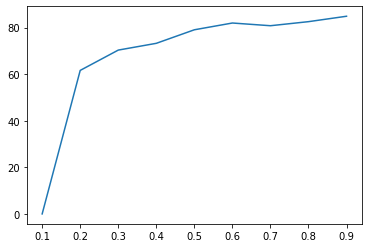

In [37]:
k = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
fig, ax = plt.subplots()
ax.plot(k, accuracy)

Lets write some text samples on your own and get them classified.

In [38]:
review_text = "Climate Change is a Myth."
product = rev_probs(review_text, alpha = 1.0)
print(product)

[-1.08825461 -0.97429526 -1.25268034]


We can see that for our example, Trump is most likely speaker of the above text with highest probablity.

In [40]:
review_text = "America is great a nation."
product = rev_probs(review_text, alpha = 1.0)
print(product)

[-14.25022324 -14.65165348 -16.16558945]


In the above example, Biden is most likely speaker of the above text with highest probablity. Although it needs to important that both presidential candiate are likely to say that and probablities are really close.

It seems like our programme is working quite nicely.

# References

1. Naive Bayes from sklearn, Accessed April 11, 2023. https://scikit-learn.org/stable/modules/naive_bayes.html
2. Stack Overflow. Preprocessing steps to follow while cleaning and extracting text data from tweets, Accessed April 11, 2023. https://codereview.stackexchange.com/questions/163446/preprocessing-steps-to-follow-while-cleaning-and-extracting-text-data-from-tweet.
3. Class Notes. Accessed April 11, 2023.
4. Pandas API Library. Accessed April 11, 2023. https://pandas.pydata.org/docs/reference/frame.html.
5. The commission on Presenditial Debate. Accessed April 11, 2023. https://www.debates.org/voter-education/debate-transcripts/september-29-2020-debate-transcript/.
6. Word Cloud Documention in python. Accessed April 11, 2023. https://pypi.org/project/wordcloud/